<a href="https://colab.research.google.com/github/mkbensalah/Change-Detection-in-Hyperspectral-Images/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
pip install spectral

In [309]:
import os
import random
import itertools
from random import shuffle
import h5py
import json
import tensorflow as tf

import numpy as np
import scipy
import scipy.io as sio # Scipy input and output
import scipy.ndimage 
from skimage.transform import rotate 
import spectral # Module for processing hyperspectral image data.
import matplotlib 
%matplotlib inline

# scikit-learn imports 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

# keras imports 
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed
from keras.optimizers import SGD
from keras.models import load_model
from keras import backend as K
from keras.utils import np_utils

In [310]:
def  load_dataset(dataset):
    """load dataset parameters from config.json"""
    
    
    with open('/content/config.json') as f:
        config = json.loads(f.read())
        params = config[dataset]
        data_1 = sio.loadmat(params['img_path_1'])['Data2009']
        data_2 = sio.loadmat(params['img_path_2'])['Data2015']
        labels = sio.loadmat(params['gt_path'])['GT_end']
        
        
    return data_1, data_2, labels

In [311]:
data_1, data_2 , labels= load_dataset("Indian_pines")



In [235]:
def apply_pca(X, num_components=75):
    """apply pca to X and return new_X"""
    
    new_X = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=num_components, whiten=True)
    new_X = pca.fit_transform(new_X)
    new_X = np.reshape(new_X, (X.shape[0],X.shape[1], num_components))
    return new_X, pca

In [236]:
def pad_with_zeros(X, margin=2):
    """apply zero padding to X with margin"""
    
    new_X = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    new_X[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return new_X

In [237]:
def create_patches(X, y, window_size=7, remove_zero_labels = True):
    """create patch from image. suppose the image has the shape (w,h,c) then the patch shape is
    (w*h,window_size,window_size,c)"""
    
    margin = int((window_size - 1) / 2)
    zero_padded_X = pad_with_zeros(X, margin=margin)
    # split patches
    patches_data = np.zeros((X.shape[0] * X.shape[1], window_size, window_size, X.shape[2]))
    patchs_labels = np.zeros((X.shape[0] * X.shape[1]))
    patch_index = 0
    for r in range(margin, zero_padded_X.shape[0] - margin):
        for c in range(margin, zero_padded_X.shape[1] - margin):
            patch = zero_padded_X[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patches_data[patch_index, :, :, :] = patch
            patchs_labels[patch_index] = y[r-margin, c-margin] + 1
            patch_index = patch_index + 1
            
    if remove_zero_labels:
        patches_data = patches_data[patchs_labels>0,:,:,:]
        patchs_labels = patchs_labels[patchs_labels>0]
        patchs_labels -= 1
    return patches_data, patchs_labels

In [238]:
def split_train_test_set(X, y, test_ratio=0.10):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [239]:
def oversample_weak_classes(X, y):
    """"balance the dataset by prforming oversample of weak classes (making each class have close labels_counts)"""
    unique_labels, labels_counts = np.unique(y, return_counts=True)
    
    print(unique_labels.shape)
    print(unique_labels)
    print(labels_counts.shape)
    print(labels_counts)
    max_count = np.max(labels_counts)
    labels_inverse_ratios = max_count / labels_counts  
    #print(labels_inverse_ratios)
    # repeat for every label and concat
    print(labels_inverse_ratios)
    new_X = X[y == unique_labels[0], :, :, :].repeat(round(labels_inverse_ratios[0]), axis=0)
    new_Y = y[y == unique_labels[0]].repeat(round(labels_inverse_ratios[0]), axis=0)
    for label, labelInverseRatio in zip(unique_labels[1:], labels_inverse_ratios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        new_X = np.concatenate((new_X, cX))
        new_Y = np.concatenate((new_Y, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(new_Y.shape[0])
    new_X = new_X[rand_perm, :, :, :]
    new_Y = new_Y[rand_perm]
    unique_labels, labels_counts = np.unique(new_Y, return_counts=True)
    
#     print(unique_labels.shape)
#     print(unique_labels)
#     print(labels_counts.shape)
#     print(labels_counts)
    return new_X, new_Y

In [240]:
def augment_data(X_train):
    """augment the data by taking each patch and randomly performing 
    a flip(up/down or right/left) or a rotation"""
    
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
        patch2 = flipped_patch
        X_train[i,:,:,:] = patch2
    
    return X_train

In [362]:
#Parameters
dataset = "Indian_pines" # Indian_pines or PaviaU or or Salinas  . check config.json
window_size = 7
num_pca_components = 30
test_ratio = 0.25

In [376]:
X_1, X_2, y = load_dataset(dataset)

X_1,pca = apply_pca(X_1,num_pca_components)
X_1_patches, y_patches = create_patches(X_1, y, window_size=window_size)
X_1_train, X_1_test, y_1_train, y_test = split_train_test_set(X_1_patches, y_patches, test_ratio)
X_1_train, y_1_train = oversample_weak_classes(X_1_train, y_1_train)
X_1_train = augment_data(X_1_train)

X_2,pca = apply_pca(X_2,num_pca_components)
X_2_patches, y_patches = create_patches(X_2, y, window_size=window_size)
X_2_train, X_2_test, y_train, y_test = split_train_test_set(X_2_patches, y_patches, test_ratio)
X_2_train, y_train = oversample_weak_classes(X_2_train, y_train)
X_2_train = augment_data(X_2_train)







y_train = np_utils.to_categorical(y_train) # convert class labels to on-hot encoding
y_test = np_utils.to_categorical(y_test)
y_train = y_train[:,-1]
print(X_1_train.shape)
print(X_1_train.ndim)
print(X_2_train.shape)
print(X_2_train.ndim)
print(y_train.shape)
print(y_train.ndim)

(2,)
[0. 1.]
(2,)
[27424  2576]
[ 1.         10.64596273]
(2,)
[0. 1.]
(2,)
[27424  2576]
[ 1.         10.64596273]
(55760, 7, 7, 30)
4
(55760, 7, 7, 30)
4
(55760,)
1


In [296]:
data = np.zeros(shape=(55760,2,7,7,30))
labels = np.zeros(shape=(55760,1))
labels = y_train
data_1 = np.array([X_1_train[0], X_2_train[0]])
data[0] = data_1
for i in range(1, 55760):
  x = np.array([X_1_train[i], X_2_train[i]])

  data[i] = x
print(data.shape)
print(data.ndim)

print(y_train.shape)
print(y_train.ndim)


(55760, 2, 7, 7, 30)
5
(55760,)
1


In [209]:
def define_model() :
    
    
    input_shape= X_train[0].shape # Define the input shape 
    C1 = 3*num_pca_components # number of filters
    
    model = Sequential()
    model.add(TimeDistributed(Conv2D(C1, (3, 3), padding='same',activation='relu'), input_shape=(2,7,7,30)))
    model.add(TimeDistributed(MaxPooling2D(2,2)))
    model.add(TimeDistributed(Conv2D(3*C1, (3, 3), padding='same', activation='relu')))
    model.add(ConvLSTM2D(16,kernel_size = (3, 3),padding = 'same', return_sequences = True))
    model.add(ConvLSTM2D(32, kernel_size = (3, 3), padding = 'same', return_sequences = False))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    print(input_shape)
    sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [210]:
model = define_model()

model.summary()

(7, 7, 30)
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_50 (TimeDis (None, 2, 7, 7, 90)       24390     
_________________________________________________________________
time_distributed_51 (TimeDis (None, 2, 3, 3, 90)       0         
_________________________________________________________________
time_distributed_52 (TimeDis (None, 2, 3, 3, 270)      218970    
_________________________________________________________________
conv_lst_m2d_13 (ConvLSTM2D) (None, 2, 3, 3, 16)       164800    
_________________________________________________________________
conv_lst_m2d_14 (ConvLSTM2D) (None, 3, 3, 32)          55424     
_________________________________________________________________
flatten_16 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)    

In [231]:
# We have already trained the model
data_1 = np.array([X_train[0], X_train[1]])

data_2= np.array([X_train[2], X_train[3]])

data = np.array([data_1, data_2])

print(data.shape)
print(data.ndim)
labels =np.array([y_train[0], y_train[1]])
print(labels.shape)
print(labels.ndim)


(2, 2, 7, 7, 30)
5
(2,)
1


In [297]:
model.fit(data, labels, batch_size=32, epochs=15)

Epoch 1/15
55760/55760 [==============================] - 217s 4ms/step - loss: 0.1122 - accuracy: 0.9617
Epoch 2/15
55760/55760 [==============================] - 219s 4ms/step - loss: 0.0643 - accuracy: 0.9785
Epoch 3/15
55760/55760 [==============================] - 224s 4ms/step - loss: 0.0601 - accuracy: 0.9794
Epoch 4/15
55760/55760 [==============================] - 220s 4ms/step - loss: 0.0525 - accuracy: 0.9820
Epoch 5/15
55760/55760 [==============================] - 213s 4ms/step - loss: 0.0631 - accuracy: 0.9784
Epoch 6/15
55760/55760 [==============================] - 211s 4ms/step - loss: 0.0674 - accuracy: 0.9768
Epoch 7/15
55760/55760 [==============================] - 211s 4ms/step - loss: 0.0682 - accuracy: 0.9760
Epoch 8/15
55760/55760 [==============================] - 211s 4ms/step - loss: 0.0666 - accuracy: 0.9768
Epoch 9/15
55760/55760 [==============================] - 212s 4ms/step - loss: 0.0686 - accuracy: 0.9757
Epoch 10/15
55760/55760 [=====================

In [305]:
model.save('/content/trained_model.h5')

In [300]:
print(model.layers[2])

In [358]:
X_1, X_2,y = load_dataset("Indian_pines")
X_1,pca = apply_pca(X_1,num_pca_components)
X_2,pca = apply_pca(X_2,num_pca_components)
height = y.shape[0]
width = y.shape[1]
patch_size = window_size
data = np.zeros(shape=(55760,2,7,7,30))
data_1 = np.array([X_1, X_2])
X = X_1
print(X_1.shape)
print(x.ndim)


(200, 200, 30)
4


In [346]:
def get_patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+patch_size)
    width_slice = slice(width_index, width_index+patch_size)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [373]:
def generate_pridected_image():
    """generate the predicted image"""
    outputs = np.zeros((height,width))

    for i in range(height-patch_size+1):
        for j in range(width-patch_size+1):
            target = y[int(i+patch_size/2), int(j+patch_size/2)]
            if target == 0 :
                continue
            else :
                image_patch=get_patch(X,i,j)
                X_test_image = image_patch.reshape(7,7,30).astype('float32')
                image_patch=get_patch(X_2,i,j)
                X_2_test_image = image_patch.reshape(7,7,30).astype('float32')
                
                X_F = np.array([X_test_image, X_2_test_image])
                X_2_F = X_F.reshape(1,X_F.shape[0],X_F.shape[1],X_F.shape[2],X_F.shape[3])
                
                prediction = (model.predict_classes(X_2_F))                         
                outputs[int(i+patch_size/2)][int(j+patch_size/2)] = prediction+1
    return outputs.astype(int)

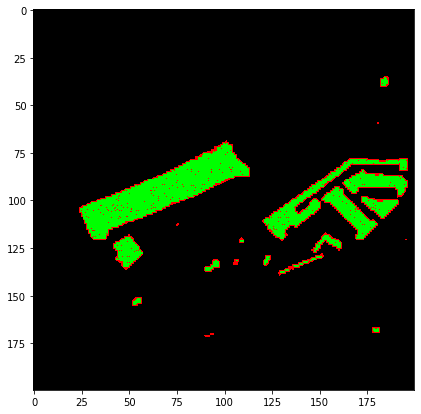

In [374]:
outputs=generate_pridected_image()
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

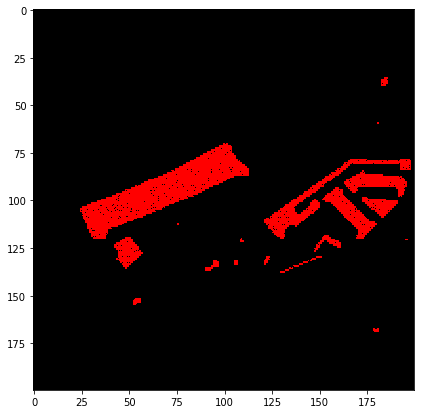

In [377]:
gt_image = spectral.imshow(classes = y,figsize =(7,7))